# 라이브러리 및 모듈 호출

In [11]:
from tensorflow.keras.datasets import cifar10
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt

# 데이터 준비

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_mean = np.mean(x_train, axis = (0, 1, 2))
x_std = np.std(x_train, axis = (0, 1, 2))

x_train = (x_train - x_mean) / x_std
x_test = (x_test - x_mean) / x_std

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.3, random_state = 777)

# sparse_categorical_crossentropy를 사용하기 위해선 (batch_size, ) 형태를 가져야함
y_train = np.squeeze(y_train)
y_val = np.squeeze(y_val)

# 이미지 제너레이터

In [4]:
batch_size = 32

train_datagen = ImageDataGenerator(horizontal_flip = True,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 30,
                                   fill_mode = 'nearest')

train_generator = train_datagen.flow(x_train, y_train, batch_size = batch_size)

val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(x_val, y_val,batch_size = batch_size)

# VGG16 모델 구성 확인

In [6]:
vgg16 = VGG16(weights = 'imagenet', input_shape = (32, 32, 3), include_top = False)
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

# 모델 구성

In [7]:
# 끝의 4개의 층만 동결 해제
for layer in vgg16.layers[:-4]:
    layer.trainable = False
    
model = Sequential()
model.add(vgg16)

# 분류기 정의
model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                        

# 모델 컴파일 및 학습

In [9]:
model.compile(optimizer = Adam(0.0001),loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

def get_step(train_len, batch_size):
    if(train_len % batch_size > 0):
        return train_len // batch_size + 1
    else:
        return train_len // batch_size

history = model.fit(train_generator,
                    epochs = 20,
                    steps_per_epoch = get_step(len(x_train), batch_size),
                    validation_data = val_generator,
                    validation_steps = get_step(len(x_val), batch_size))

Epoch 1/20
1094/1094 [==============================] - 37s 33ms/step - loss: 0.7199 - acc: 0.7470 - val_loss: 0.8113 - val_acc: 0.7300
Epoch 2/20
1094/1094 [==============================] - 36s 33ms/step - loss: 0.6993 - acc: 0.7552 - val_loss: 0.7023 - val_acc: 0.7567
Epoch 3/20
1094/1094 [==============================] - 36s 33ms/step - loss: 0.6745 - acc: 0.7629 - val_loss: 0.6847 - val_acc: 0.7692
Epoch 4/20
1094/1094 [==============================] - 36s 33ms/step - loss: 0.6411 - acc: 0.7750 - val_loss: 0.7321 - val_acc: 0.7521
Epoch 5/20
1094/1094 [==============================] - 36s 33ms/step - loss: 0.6222 - acc: 0.7816 - val_loss: 0.7143 - val_acc: 0.7631
Epoch 6/20
1094/1094 [==============================] - 36s 33ms/step - loss: 0.5966 - acc: 0.7914 - val_loss: 0.6572 - val_acc: 0.7743
Epoch 7/20
1094/1094 [==============================] - 37s 33ms/step - loss: 0.5726 - acc: 0.8010 - val_loss: 0.6657 - val_acc: 0.7783
Epoch 8/20
1094/1094 [==========================

# 학습과정 시각화

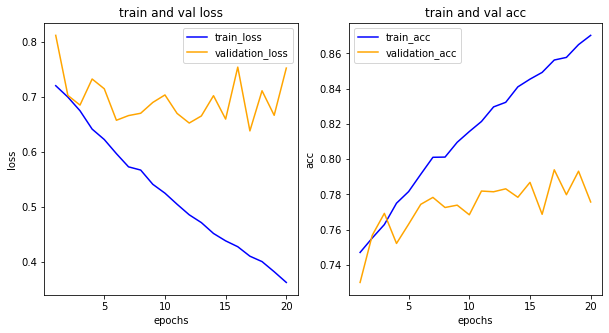

In [12]:
his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss']

epochs = range(1,len(loss)+1)
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,2,1)
ax1.plot(epochs, loss, color='b', label='train_loss')
ax1.plot(epochs, val_loss, color='orange', label='validation_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

ax2 = fig.add_subplot(1,2,2)
ax2.plot(epochs, acc, color='b', label='train_acc')
ax2.plot(epochs, val_acc, color='orange', label='validation_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

# 참고 : 가중치 전이하기
- A 모델의 가중치를 B 모델에 전이
    - A 모델: model
    - B 모델: transfer_model
    - A 모델과 B 모델의 구조가 같다는 가정 전제
    - set_weights: 가중치 설정
    - get_weights: 모델의 가중치를 가져옴

In [ ]:
for i in range(len(model.layers) - 1):
    transfer_model.layers[i].set_weights(model.layers[i].get_weights())